### PRÁCTICA 4 :


*opción 1*

Nuestro objetivo es trabajar con los datos de biciMad para estudiar la demanda de este servicio y lo realizaremos intentando  obtener los siguientes resultados.

* Cuántas salidas y entradas de bicicletas hay por barrios.
* Cómo afecta el día de la semana al uso de biciMad. 
* Salidas menos entradas para ver el uso porcentual por barrio.
* La máxima demanda de bicicletas en un barrio.
* Las conexiones mas usuales entre las distintas estaciones
* El crecimiento de la demanda del servicio a lo largo del tiempo.

*opción 2*

Nuestro objetivo es trabajar con los datos de biciMad para estudiar su optimización en la distribución de las bicicletas y ver cuales serían las paradas que debería hacer un hipotético camión reponedor para aumentar la eficiencia.




In [1]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as sf
from pyspark.sql.types import StringType

from funciones_plot import *



data_path = "datos/sample_10e4.json"

spark = SparkSession.builder.getOrCreate()

df = spark.read.json(data_path)
df_geo = spark.read.csv("datos/bases_bicimad.csv", header=True)

df_new = preprocess(df, df_geo)

### Ideas:
* **Mapear** cuantas salidas y entradas hay en un barrio
* **Posibilidad** estudiarlo como grafo con el groupby de idea3
* **Grafico** L M X J V S D, luego hacer un collect del año entero
* Salidas menos entradas para ver cuantas en uso en barrios, por porcentajes, por barrio.
* **Maxima** cantidad de bici en un momento dado
* **Estudio global:** plot de 12 meses de salidas/ dias y tarta de portentaje de uso global (sumatorio de años) de cada año 
* **Conclusion:** que barrios son los más activos, si ha aumentado el uso
* Anexo de edades

In [2]:
df_geo3   = df_geo.withColumnRenamed('Número', 'plug_station')
df_geo3   = df_geo3.withColumn('plug_station', sf.col('plug_station').cast(StringType()))
df        = spark.read.json(data_path)
df        = df.withColumn('idplug_station', sf.col('idplug_station').cast(StringType()))
df        = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').cast(StringType()))
df        = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').substr(2, 10))

In [3]:
df.limit(5).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013
2,"(59e46b0c2f38432040c33521,)",4,24,172,22,136,"([(Row(coordinates=[-3.677193, 40.457155499722...",2055,2017-10-10,2205231ee045b927ff57c58d4ad42f197b89ada6f43d83...,1,28045
3,"(59adcf3b2f38432f98f3685b,)",5,10,109,22,51,"([(Row(coordinates=[-3.68992979972222, 40.4254...",848,2017-08-31,48a8905d6e28ad0f4e4e64cad0b0163e7e932a31725171...,1,28005
4,"(595ccc722f38430f00d48853,)",4,1,101,6,45,"([(Row(coordinates=[-3.6816081, 40.4220885], t...",646,2017-06-28,3848bb88e9c394913370e85948a0ef0d4064e7f7bea177...,1,28004


Vamos a centrar nuestro análisis en los barrios, para ello primero analizaremos un caso concreto

el de **Inserta barrio**

In [4]:
df_barrios = df_geo3.select('plug_station', 'Barrio')
df_barrios.printSchema()

root
 |-- plug_station: string (nullable = true)
 |-- Barrio: string (nullable = true)



In [5]:
df_unido_llegadas = df.join(df_barrios, df_barrios.plug_station ==  df.idplug_station,"left")
df_unido_llegadas = df_unido_llegadas.withColumnRenamed('Barrio', 'Barrio_L')

df_unido_salidas  = df.join(df_barrios, df_barrios.plug_station ==  df.idunplug_station,"left")
df_unido_salidas  = df_unido_salidas.withColumnRenamed('Barrio', 'Barrio_S')

In [6]:
df_unido_llegadas.limit(5).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,plug_station,Barrio_L
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004,58,01-04 JUSTICIA
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013,90,04-01 RECOLETOS
2,"(59e46b0c2f38432040c33521,)",4,24,172,22,136,"([(Row(coordinates=[-3.677193, 40.457155499722...",2055,2017-10-10,2205231ee045b927ff57c58d4ad42f197b89ada6f43d83...,1,28045,172,02-06 PALOS DE MOGUER
3,"(59adcf3b2f38432f98f3685b,)",5,10,109,22,51,"([(Row(coordinates=[-3.68992979972222, 40.4254...",848,2017-08-31,48a8905d6e28ad0f4e4e64cad0b0163e7e932a31725171...,1,28005,109,04-06 CASTELLANA
4,"(595ccc722f38430f00d48853,)",4,1,101,6,45,"([(Row(coordinates=[-3.6816081, 40.4220885], t...",646,2017-06-28,3848bb88e9c394913370e85948a0ef0d4064e7f7bea177...,1,28004,101,04-02 GOYA


In [7]:
salidas     = ['idunplug_station', 'unplug_hourTime', 'Barrio_S']
df_salidas  = df_unido_salidas.select(*salidas).groupBy('Barrio_S').count()
df_salidas = df_salidas.withColumnRenamed('count', 'salidas')

llegadas    = ['idplug_station', 'Barrio_L']
df_llegadas = df_unido_llegadas.select(*llegadas).groupBy('Barrio_L').count()
df_llegadas = df_llegadas.withColumnRenamed('count', 'llegadas')

Ahora que tenemos agrupados los datos en una cantidad pequeña , 35, podemos hacer un collect para hacer un plot

In [8]:
df_grafico = df_llegadas.join(df_salidas
                              , df_salidas.Barrio_S ==  df_llegadas.Barrio_L,"left")
df_grafico = df_grafico.select('Barrio_L', 'llegadas', 'salidas')
df_grafico = df_grafico.withColumnRenamed('Barrio_L', 'Barrio')
df_grafico = df_grafico.where(sf.col("Barrio").isNotNull())
df_grafico = df_grafico.orderBy('llegadas')

<AxesSubplot:title={'center':'Visualización de la demanda de las estaciones'}, xlabel='Barrio'>

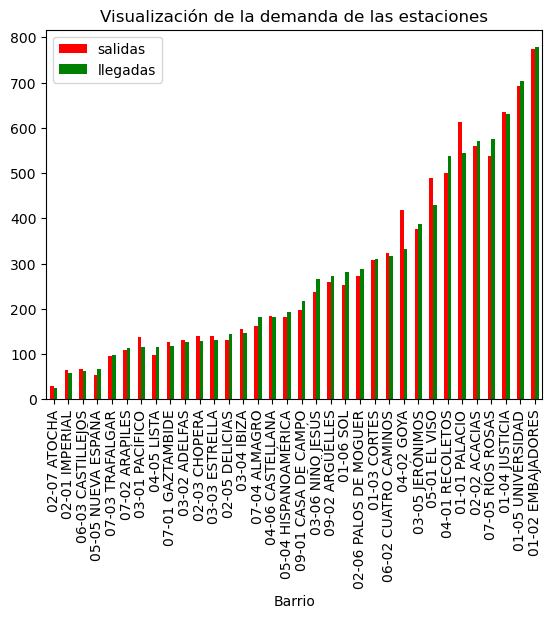

In [9]:
df_grafico.toPandas().plot.bar(
    x     = 'Barrio', 
    y     = ['salidas','llegadas'], 
    color = ['red','green'],
    title = "Visualización de la demanda de las estaciones"
)

### Estudio por años

Estudiamos el incremento de la demanda en los años

In [10]:
df_unido_salidas.limit(2).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,plug_station,Barrio_S
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004,None,None
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013,40,01-02 EMBAJADORES


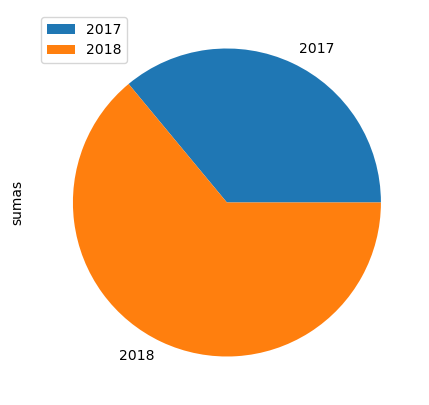

In [11]:
df_year = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').substr(1, 4))\
            .groupBy('unplug_hourTime')\
            .count()
df_year.limit(5).toPandas()
df_grafico_tarta = pd.DataFrame({'sumas': [3602, 6398]},
                  index=['2017', '2018'])
plot = df_grafico_tarta.plot.pie(y='sumas', figsize=(5, 5))

* Aumento significativo! podemos hacer una comparacion local en barrios

### Pico máximo de uso
La máxima demanda de bicicletas en un barrio

In [12]:
df_pico = df_unido_salidas.select(*salidas)\
                        .where(sf.col("Barrio").isNotNull())\
                        .groupBy('unplug_hourTime')\
                        .count()\
                        .agg({'count': 'max'})\
                        .withColumnRenamed('max(count)', 'maximo_diario')
                        

df_pico.toPandas()
# aAhora si 

,maximo_diario
0,44


### Análisis por dias

In [13]:
df_original = spark.read.json("datos/sample_10e4.json")

##### Primero preparamos los datos



* Preparación fechas

In [14]:
# esperar al final

* Preparación ids

In [15]:
# esperar al final

Ahora que tenemos tratados los datos vamos a ilustrar nuestro análisis

* ¿Cuál ha sido la tendencia de uso por semana en los años del análisis?

# Uso por semana en cada año

El gráfico representa la cantidad de movimientos realizados por semana en cada año.

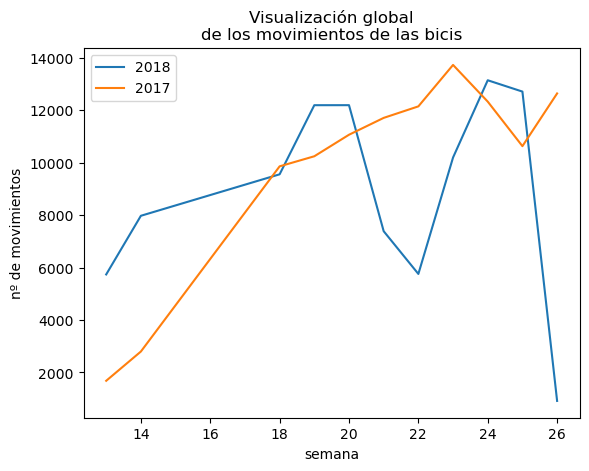

In [16]:
plot_analisys_by_year(df_new)

Nos gustaría estudiar dentro de esta tendencia general 

como se comporta BiciMad dentro de cada semana para ver si podemos encontrar otras tendenciasb

#### Análisis por días de la semana
Cómo afecta el día de la semana al uso de biciMad

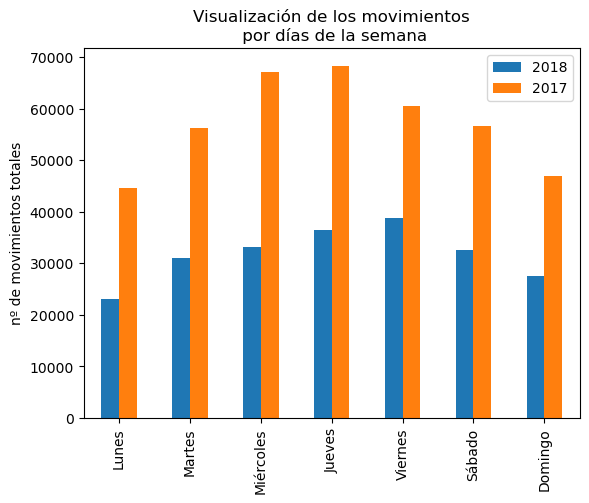

In [17]:
plot_analisys_by_day(df_new, total=True)

Mantiene la tendencia general vista antes pero además podemos ver un comportamiento creciente hasta que llega
el fin de semana, de forma cíclica

Parece que encontramos gran uniformidad en los datos, hay que tener en cuenta que este es un estudio global, por lo que nos está diciendo que durante todos los días de la semana se usan relativamente igual todas las bicis por Madrid.

Ahora bien, queremos observar en qué zonas se mueven más unos días y en qué otras zonas se mueven otros días.


### Visualización de los movimientos semanales de un barrio concreto 

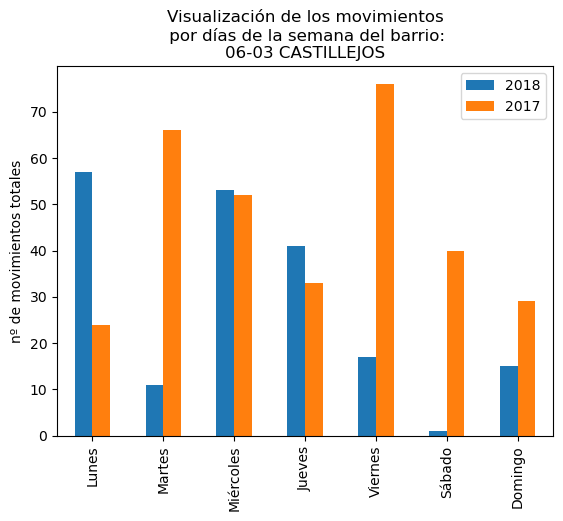

In [18]:
barrio = "06-03 CASTILLEJOS"
plot_analisys_by_day(df_new, barrio)

El pico de uso se desplaza del **viernes en 2017 a lunes en 2018**
Es notable el descenso de uso los sábados, en general el comportamiento de los usuarios ha variado mucho

Esta elección ha sido aleatoria. Vamos ahora a buscar estadísticamente barrios interesantes de los que buscar resultados.

### Agrupamos toda la información anterior por barrios, para realizar un análisis global

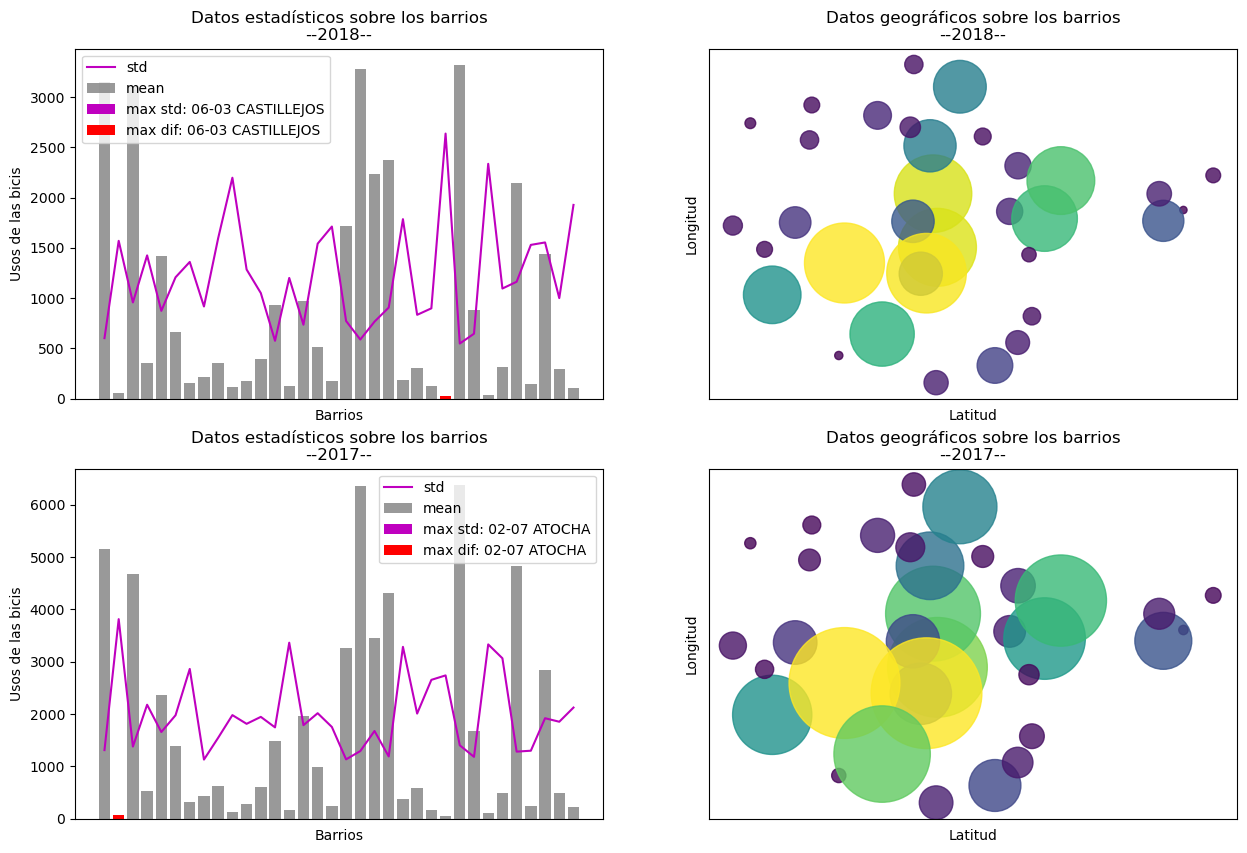

In [19]:
plot_stats(df_new)

De media, observamos mayores movimientos por el centro (los puntos amarillos) mientras que a las afueras menor uso de las bicicletas. Esto se puede deber a que disponen de más puntos donde usarlas

Parece interesante estudiar su comportamiento separando los dias de entre semana de los fines de semana

### Vamos a analizar los datos diarios de los barrios que nos han dado mayores desviaciones típicas y diferencia

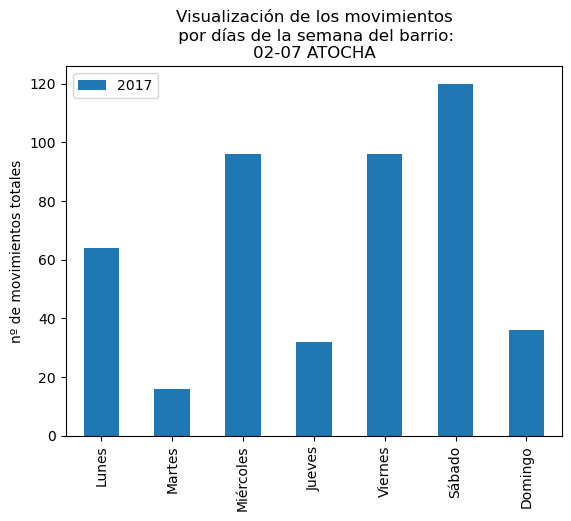

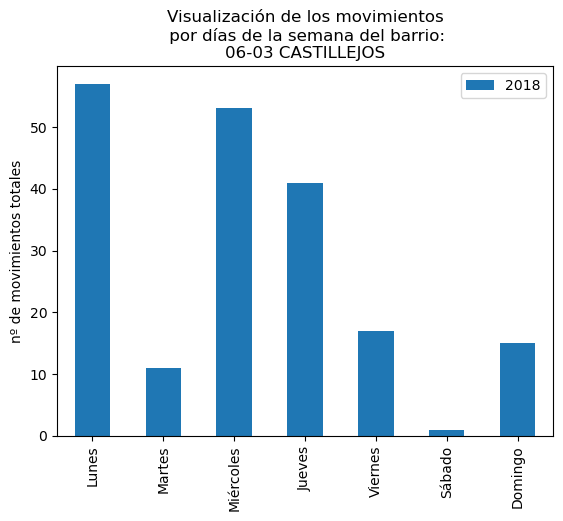

In [20]:
barrio_2017 = "02-07 ATOCHA"
barrio_2018 = "06-03 CASTILLEJOS"

plot_analisys_by_day(df_new, barrio_2017, years=["2017"])
plot_analisys_by_day(df_new, barrio_2018, years=["2018"])

 - Año 2017:
 
  - **02-07 ATOCHA**: se observa una diferencia considerable en los días viernes y sabado, es decir, durante la llegada del fin de semana es una zona bastante transitada a diferencia de los demás días de la semana.

 - Año 2018:
  
  - **06-03 CASTILLEJOS**: Se observa un claro descenso a lo largo del transcurso de la semana. Dejando los fines de semana casi inactivos en comparación con los días laborales.


Es interesante ver que los martes es un mínimo en los días laborales en dos barrios con comportamientos muy opuestos

### Estudio separado de días laborables y no laborables

 - Entre semana: Lunes, ..., Viernes
 - Fin de semana: Viernes, Sábado, Domingo

* De esta forma tendremos una perspectiva más correcta de como son los ciclos semanales

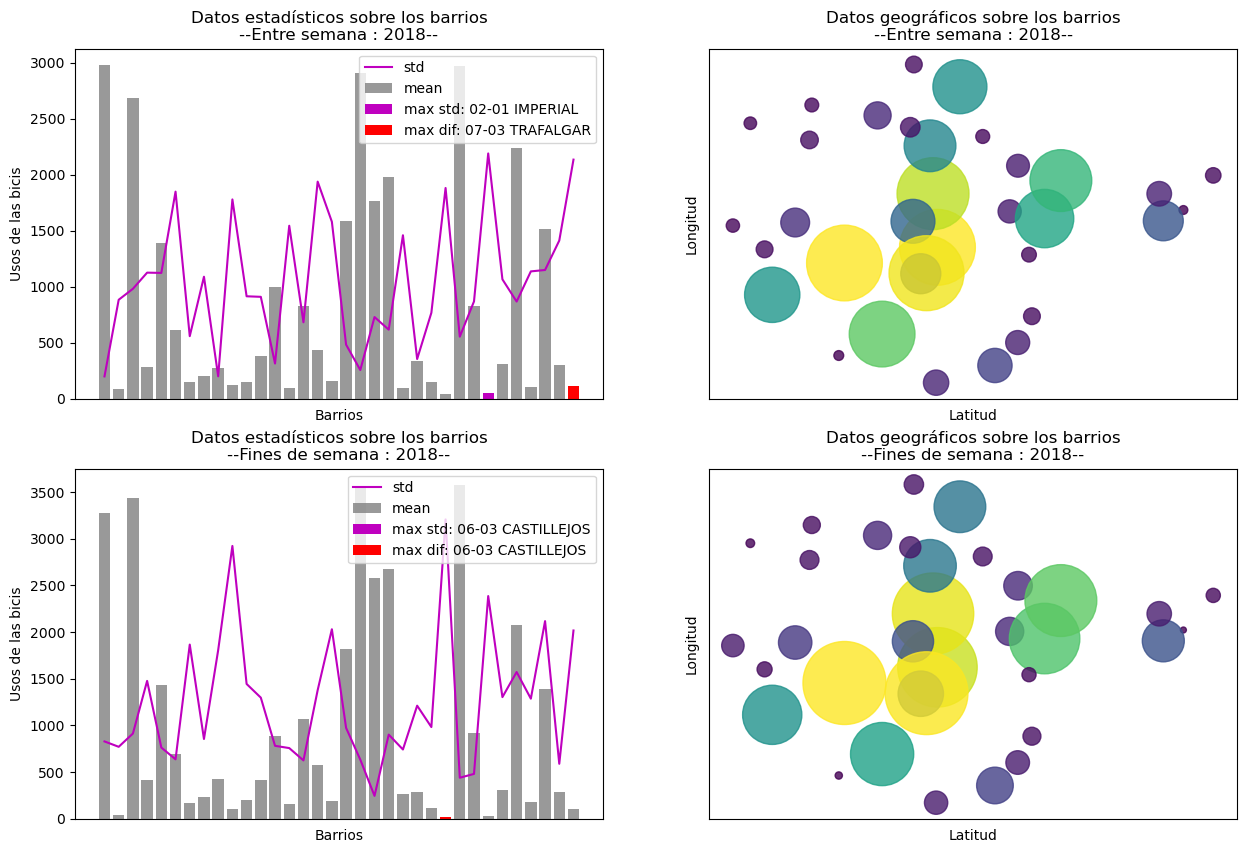

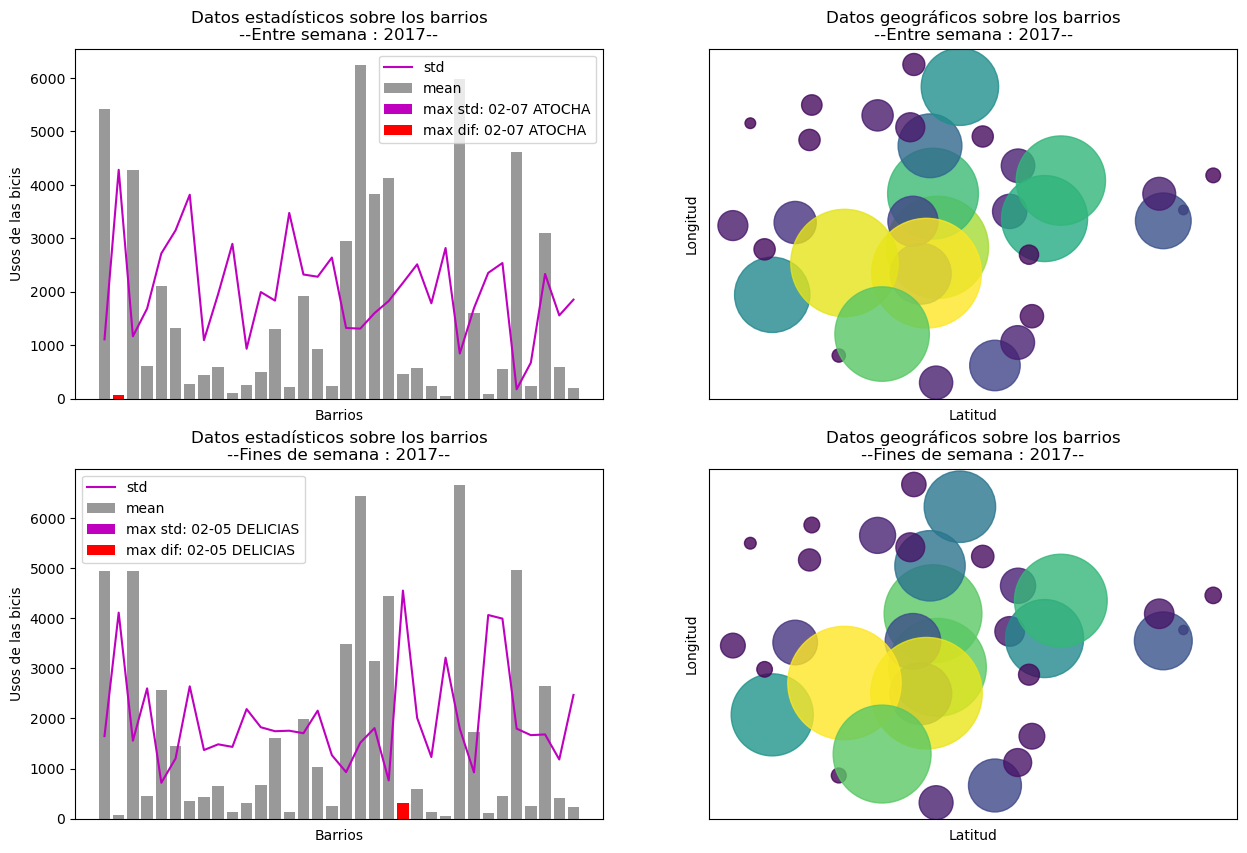

In [21]:
plot_stats_by_weekends(df_new)

Observamos que las tendencias son similares, realizamos un estudio por estaciones para ver si podemos encontrar diferencias significativas, de forma que en función de la estacón el camión que repone las bicicletas debería seguir un camino u otro.

### Estudio por estaciones

* Arreglando plot_stats_by_seasons

In [29]:
plot_stats_by_seasons(df_estaciones)

Py4JJavaError: An error occurred while calling o865.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 241.0 failed 1 times, most recent failure: Lost task 0.0 in stage 241.0 (TID 257) (DESKTOP-501MU8B executor driver): java.net.SocketException: Software caused connection abort: recv failed
	at java.net.SocketInputStream.socketRead0(Native Method)
	at java.net.SocketInputStream.socketRead(Unknown Source)
	at java.net.SocketInputStream.read(Unknown Source)
	at java.net.SocketInputStream.read(Unknown Source)
	at java.io.BufferedInputStream.fill(Unknown Source)
	at java.io.BufferedInputStream.read(Unknown Source)
	at java.io.DataInputStream.readInt(Unknown Source)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:75)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage10.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.ContextAwareIterator.hasNext(ContextAwareIterator.scala:39)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:320)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:57)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:440)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:274)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.net.SocketException: Software caused connection abort: recv failed
	at java.net.SocketInputStream.socketRead0(Native Method)
	at java.net.SocketInputStream.socketRead(Unknown Source)
	at java.net.SocketInputStream.read(Unknown Source)
	at java.net.SocketInputStream.read(Unknown Source)
	at java.io.BufferedInputStream.fill(Unknown Source)
	at java.io.BufferedInputStream.read(Unknown Source)
	at java.io.DataInputStream.readInt(Unknown Source)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:75)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage10.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.ContextAwareIterator.hasNext(ContextAwareIterator.scala:39)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:320)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:57)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:440)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:274)


<Figure size 1500x2000 with 0 Axes>

### Estudio de las diferencias de entradas y salidas en cada una de los barrios

 - Cuanto más grande sea el punto en el gráfico de la derecha, mayores diferencias tiene entre salidas y llegadas al barrio.

In [ ]:
plot_diferencias_entrada_salida_por_barrios(df_new)

### Conclusiones 

Tras el estudio de los datos hemos llegado a las siguientes conclusiones

* Cuántas salidas y entradas de bicicletas hay por barrios.
* Cómo afecta el día de la semana al uso de biciMad. 
* Salidas menos entradas para ver el uso porcentual por barrio.
* La máxima demanda de bicicletas en un barrio.
* Las conexiones mas usuales entre las distintas estaciones
* El crecimiento de la demanda del servicio a lo largo del tiempo.



### Anexo :


Las funciones que han sido utilizadas e importadas desde funciones_plot.py para facilidad de lectura.
No hace falta ejecutarlas, el objetivo del anexo es incluir lo que ha sido utilizado.





In [ ]:
# esperar al final